In [1]:
from collections import Counter
import numpy as np
import Constants
# from DataManager import DataError, DataManager
# from Experiment import Experiment

In [2]:
RECALL_TSV = '../data/recall_oriented.tsv'
PRECISION_TSV = '../data/precision_oriented.tsv'
UNIFORM_TSV = '../data/uniformly_sampled.tsv'

RECALL_DATA = '../data/hydrated_recall.json'
PRECISION_DATA = '../data/hydrated_precision.json'
UNIFORM_DATA = '../data/hydrated_uniform.json'

LANG_CODES = '../data/lang_codes.txt'

In [3]:
class DataError(Exception):
    def __init__(self, message):
        self.message = message


class DataManager(object):

    def __init__(self,
                 annotated_tsv=Constants.RECALL_TSV,
                 retrieved_data=Constants.RECALL_DATA,
                 lang_codes_file=Constants.LANG_CODES):
        self.initialized = False
        self.annotated_tsv = annotated_tsv
        self.retrieved_data = retrieved_data
        self.lang_codes_file = lang_codes_file

    def initialize(self, splits=(0.60, 0.20, 0.20), shuffle=True):
        if self.initialized:
            return
        self.lang_codes = self._load_lang_codes()
        self.tweet_labels, self.canonical_inv_idx = \
            self._load_tweet_labels()
        self.tweet_text, self.hydrated_inv_idx = self._load_tweet_text()
        self._split_dataset(splits, shuffle)
        self.initialized = True

    def _split_dataset(self, splits, shuffle):
        if type(splits) not in [list, tuple] or len(splits) != 3:
            err_msg = 'splits should be collection (list or tuple) of length 3'
            raise DataError(err_msg)
        if sum(splits) != 1.0:
            raise DataError('split percentages should sum to 1.0')

        # percentage_split() code source: http://bit.ly/2buzsDm
        def percentage_split(seq, percentages):
            if shuffle:
                np.random.shuffle(seq)
            cdf = np.cumsum(percentages)
            stops = map(int, cdf * len(seq))
            return [seq[a:b] for a, b in zip([0] + stops, stops)]

        self.X_train, self.y_train = [], []
        self.X_dev, self.y_dev = [], []
        self.X_test, self.y_test = [], []
        for lang in self.hydrated_inv_idx:
            if lang not in self.lang_codes:
                continue
            tweet_ids = list(self.hydrated_inv_idx[lang])
            train, dev, test = percentage_split(tweet_ids, splits)
            self.X_train += [self.tweet_text[t] for t in train]
            self.y_train += [lang] * len(train)
            self.X_dev += [self.tweet_text[t] for t in dev]
            self.y_dev += [lang] * len(dev)
            self.X_test += [self.tweet_text[t] for t in test]
            self.y_test += [lang] * len(test)

    def _load_lang_codes(self):
        lang_codes = set()
        with open(self.lang_codes_file) as fp:
            for line in fp:
                lang_codes.add(line.strip())
        return lang_codes

    def _update_inverted_index(self, inv_idx, lang, tweet_id):
        if lang in inv_idx:
            inv_idx[lang].add(tweet_id)
        else:
            inv_idx[lang] = set([tweet_id])
        return inv_idx

    def _load_tweet_labels(self):
        D = {}
        inv_idx = {}
        with open(self.annotated_tsv) as tsv:
            for line in tsv:
                t_lang, t_id = line.strip().split('\t')
                D[t_id] = t_lang
                self._update_inverted_index(inv_idx, t_lang, t_id)
        return D, inv_idx

    def _load_tweet_text(self):
        D = {}
        inv_idx = {}
        with open(self.retrieved_data) as fp:
            for line in fp:
                stripped = line.strip()[2:-2]  # remove quotes and brackets
                t_id, t_text = stripped.split('\",\"')
                D[t_id] = t_text
                self._update_inverted_index(inv_idx,
                                            self.tweet_labels[t_id],
                                            t_id)
        return D, inv_idx

    def training_data(self):
        if not self.initialized:
            raise DataError('Must call initialize() first')
        return self.X_train[:], self.y_train[:]

    def dev_data(self):
        if not self.initialized:
            raise DataError('Must call initialize() first')
        return self.X_dev[:], self.y_dev[:]

    def test_data(self):
        if not self.initialized:
            raise DataError('Must call initialize() first')
        return self.X_test[:], self.y_test[:]

    def hydrated_diff(self):
        if not self.initialized:
            raise DataError('Must call initialize() first')
        for lang in self.lang_codes:
            try:
                diff = (len(self.canonical_inv_idx[lang]) -
                        len(self.hydrated_inv_idx[lang]))
            except KeyError:
                diff = None
            print('{}: {}'.format(lang, diff))


In [4]:
import numpy as np
import sklearn.linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


class Experiment(object):
    '''
    Organize the process of getting data, building a classifier,
    and exploring new representations. Modified from and credit to:
    Matthew Stone, CS 533, Spring 2017 - Classifier Patterns
    '''

    def __init__(self,
                 data_manager,
                 classifier,
                 cleaning_operations,
                 filtering_operations,
                 vectorizer,
                 shuffle=False,
                 seed=None):
        # TODO: Change name/defaults of some of these parameters
        '''set up the problem of learning a classifier from a data manager'''
        self.data_manager = data_manager
        self.classifier = classifier
        self.cleaning_operations = cleaning_operations
        self.filtering_operations = filtering_operations
        self.vectorizer = vectorizer
        self.shuffle = shuffle
        self.seed = seed
        self.initialized = False

    def initialize(self):
        '''materialize the training data, dev data and test data as matrices'''
        if self.initialized:
            return
        self.X_train_text, self.y_train_text = \
            self.data_manager.training_data()
        self.X_dev_text, self.y_dev_text = \
            self.data_manager.dev_data()
        self.X_test_text, self.y_test_text = \
            self.data_manager.test_data()
        self._filter()
        self._clean()
        self._extract_features()
        if self.shuffle:
            self._shuffle()
        self.initialized = True

    def _clean(self):
        '''
        The order of the list of operations matters! It is recommended to have
            'replace_newline_char' be the first in cleaning_operations.
            Cleaning will not remove data!
        '''
        for op in self.cleaning_operations:
            if isinstance(op, tuple):
                f = op[0]
                args = op[1]
            else:
                f = op
                args = {}
            f(self.X_train_text, self.y_train_text, **args)
            f(self.X_dev_text, self.y_dev_text, **args)
            f(self.X_test_text, self.y_test_text, **args)


    def _filter(self):
        '''
        The order of the list of operations matters! Filtering will remove data!
        '''
        for op in self.filtering_operations:
            if isinstance(op, tuple):
                f = op[0]
                args = op[1]
            else:
                f = op
                args = {}
            self.X_train_text, self.y_train_text = \
                f(self.X_train_text, self.y_train_text, **args)
            self.X_dev_text, self.y_dev_text = \
                f(self.X_dev_text, self.y_dev_text, **args)
            self.X_test_text, self.y_test_text = \
                f(self.X_test_text, self.y_test_text, **args)
                
                
    def _extract_features(self):
        '''
        Vectorizer should return NxM matrix where N is number of samples and
            M is number of features (dimension)
        '''
        self.X_train = self.vectorizer.fit_transform(self.X_train_text)
        self.X_dev = self.vectorizer.transform(self.X_dev_text)
        self.X_test = self.vectorizer.transform(self.X_test_text)

        # TODO: Ensure no zero vectors or any funny business
        # TODO: convert labels to integers and maintain a mapping
        S = list(set(self.y_train_text + self.y_dev_text + self.y_test_text))
        self.lang_to_num = dict(zip(S, range(len(S))))
        self.num_to_lang = {v: k for k, v in self.lang_to_num.iteritems()}

        conv = lambda x: self.lang_to_num[x]
        self.y_train = map(conv, self.y_train_text)
        self.y_dev = map(conv, self.y_dev_text)
        self.y_test = map(conv, self.y_test_text)

    def _shuffle(self):
        if self.seed:
            np.random.seed(self.seed)
        p = np.random.permutation(len(self.y_train))
        self.X_train = self.X_train[p]
        self.X_train_text = [self.X_train_text[i] for i in p]
        self.y_train = [self.y_train[i] for i in p]
        self.y_train_text = [self.y_train_text[i] for i in p]

    
    def fit_and_validate(self):
        '''train the classifier and assess predictions on dev data'''
        if not self.initialized:
            self.initialize()
        self.classifier.fit(self.X_train, self.y_train)
        self.dev_predictions = self.classifier.predict(self.X_dev)
        self.dev_accuracy = \
            sklearn.metrics.accuracy_score(self.y_dev, self.dev_predictions)

    '''
    @classmethod
    def transform(cls, expt, operation, classifier):
        'use operations to transform the data and set up new expt'
        if not expt.initialized:
            expt.initialize()
        result = cls(expt.data, classifier)
        result.X_train, result.y_train = operation(expt.X_train, expt.y_train)
        result.X_dev, result.y_dev = operation(expt.X_dev, expt.y_dev)
        result.X_test, result.y_test = operation(expt.X_test, expt.y_test)
        result.initialized = True
        return result
    '''


In [5]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
import re
import string


def decode_unicode(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.decode('utf-8')
    return X, y


def remove_newline_char(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.replace(r'\n', ' ')
    return X, y


def remove_RT(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.replace('RT', '')
    return X, y


def remove_urls(X, y):
    pattern = 'http\S+'
    p = re.compile(pattern)
    for idx, text in enumerate(X):
        if p.search(text):
            X[idx] = p.sub('', text)
    return X, y


def remove_handles(X, y):
    pattern = '@[a-z,A-Z]*'
    p = re.compile(pattern)
    for idx, text in enumerate(X):
        if p.search(text):
            X[idx] = p.sub('', text)
    return X, y


def remove_hashtags(X, y):
    pattern = '#[a-z,A-Z]*'
    p = re.compile(pattern)
    for idx, text in enumerate(X):
        if p.search(text):
            X[idx] = p.sub('', text)
    return X, y

def remove_html_garbage(X,y):
    filt = [r'&lt', r'&gt;', r'&amp;']
    for indx, text in enumerate(X):
        for f in filt:
            text = text.replace(f, '')
        X[indx] = text
    return X, y
            
def remove_punctutation(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.translate(None, string.punctuation)
    return X, y


def remove_emojis(X, y, emojis):
    for idx, x in enumerate(X):
        for emoji in emojis:
            x = x.replace(emoji, '')
        X[idx] = x
    return X, y


In [7]:
dm = DataManager(RECALL_TSV, RECALL_DATA, LANG_CODES)
dm.initialize(shuffle=True, splits=(.8,.1,.1))

In [8]:
import cPickle as pickle
with open('../data/emoji_unicode.pkl', 'rb') as f:
    emojis = pickle.load(f)

In [9]:
import time

# langs_to_use = ['es', 'fr', 'en', 'de', 'uk', 'ru']
# langs_to_use = ['sr', 'bs', 'hr']
# langs_to_use = ['zh-CN', 'zh-TW', 'vi']
langs_to_use = ['en', 'zh-CN']

X, y = dm.training_data()

def filt_by_lang(X, y, langs_to_use):
    indices = []
    for idx, lang in enumerate(y):
        if lang in langs_to_use:
            indices.append(idx)
    return [X[i] for i in indices], [y[i] for i in indices]

def filt_by_length(X, y):
    indices = []
    for idx, tweet in enumerate(X):
        if len(tweet) <= 140:
            indices.append(idx)
    return [X[i] for i in indices], [y[i] for i in indices]

t0 = time.time()
X1, y1 = zip(*filter(lambda pair: pair[1] in langs_to_use, zip(X, y)))
print('time elapsed: {}'.format(time.time() - t0))

t0 = time.time()
X2, y2 = filt_by_lang(X, y, langs_to_use)
print('time elapsed: {}'.format(time.time() - t0))

print len(X1), len(y1)
print len(X2), len(y2)

time elapsed: 0.115460157394
time elapsed: 0.00913786888123
1288 1288
1288 1288


In [10]:
identity = lambda x: np.array(x)
# vectorizer = TfidfVectorizer(sublinear_tf=True,
#                              smooth_idf=True,
#                              ngram_range=(1, 2),
#                              analyzer='word')
vectorizer = TfidfVectorizer(sublinear_tf=True,
                             smooth_idf=True,
                             ngram_range=(1, 2),
                             analyzer='char')


classifier = \
sklearn.linear_model.SGDClassifier(loss="log",
                                   penalty="elasticnet",
                                   n_iter=5)

# classifier = \
#     sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)

# classifier = \
#     sklearn.

clean_ops = [
    decode_unicode, remove_newline_char, remove_RT, remove_urls,
    remove_handles, remove_hashtags, remove_html_garbage,
    (remove_emojis, {'emojis': emojis})
    
]
filter_ops = [
    (filt_by_lang, {'langs_to_use': langs_to_use}), filt_by_length
]
kien_filter_opts = [filt_by_length]
empty_ops = []
expt = Experiment(dm,
                  classifier=classifier,
                  cleaning_operations=clean_ops,
                  filtering_operations=empty_ops,
                  vectorizer=vectorizer,
                  shuffle=True)
expt.initialize()

In [11]:

print len(expt.X_train_text)
vectorizer = CountVectorizer(analyzer='char', lowercase=False)
#     vectorizer.fit(X_train)
vectorizer.fit(expt.X_train_text)
v = vectorizer.vocabulary_
print len(v)
def convert_text_to_indx(X_train_text):
    X_train_idx = []
    for tweet in X_train_text:
        temp = []
        for char in tweet:
            if (char) in v:
                temp.append(v[char])
            else:
                temp.append(len(v) + 1)
        X_train_idx.append(temp)
    return X_train_idx
X_train_idx = convert_text_to_indx(expt.X_train_text)
X_val_idx = convert_text_to_indx(expt.X_dev_text)
X_test_idx = convert_text_to_indx(expt.X_test_text)
print len(reduce(lambda a,b: a if len(a)>=len(b) else b, X_train_idx))

# print X_train_idx
# for i, j in zip(X_train_idx, expt.X_train_text):
#     if len(i) != len(j):
#         print len(i), len(j)
# def mapTweet(sentence, vocab = v):
#     result = []
#     count = 0
#     for char in (sentence):
# #         print repr(word)
#         if (char) in vocab:
#             result.append(vocab[char])
#         else:
#             result.append(len(vocab)+1)
#         count +=1 
#     return result

# from multiprocessing import Pool
# pool = Pool(3)
# result = pool.map_async(mapTweet, expt.X_train_text)
# pool.close()
# pool.join()

# X = tryCNN(expt.X_train_text, expt.y_train)
# print mapTweet(expt.X_train_text[15])
# print mapTweet(expt.X_train_text[10])
# print (expt.X_train_text[10])
# print v[i for i in v.keys()[:10]]
# keys = v.keys()[:10]
# print [v[i] for i in keys]
# print keys
# print expt.y_train

54835
6863
151


In [12]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
import pandas as pd
from keras.utils import plot_model

NUM_CLASS = 69
MAX_LEN = 151

X_train_idx = sequence.pad_sequences(X_train_idx, MAX_LEN)
X_val_idx = sequence.pad_sequences(X_val_idx, MAX_LEN)
X_test_idx = sequence.pad_sequences(X_test_idx, MAX_LEN)
y_train_mat = pd.get_dummies(pd.Series(expt.y_train)).as_matrix()
y_val_mat = pd.get_dummies(pd.Series(expt.y_dev)).as_matrix()
y_test_mat = pd.get_dummies(pd.Series(expt.y_test)).as_matrix()

class CNN():
    def __init__(self, max_features, embedding_dims, maxlen, filters, hidden_dims):
        model = Sequential()

        # we start off with an efficient embedding layer which maps
        # our vocab indices into embedding_dims dimensions
        model.add(Embedding(max_features,
                            embedding_dims,
                            input_length=maxlen))
        model.add(Dropout(0.2))

        # we add a Convolution1D, which will learn filters
        # word group filters of size filter_length:
        model.add(Conv1D(filters,
                         3,
                         padding='valid',
                         activation='relu',
                         strides=1))
        # we use max pooling:
        model.add(GlobalMaxPooling1D())

        # We add a vanilla hidden layer:
        model.add(Dense(hidden_dims))
        model.add(Dropout(0.2))
        model.add(Activation('relu'))

        # We project onto a single unit output layer, and squash it with a sigmoid:
        model.add(Dense(NUM_CLASS))
        model.add(Activation('sigmoid'))

        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
              metrics=['accuracy'])
        self.model = model
    def train(self, x, y, x_val, y_val):
        self.model.fit(x, y, batch_size=64, epochs=40, 
                       validation_data=(x_val, y_val))
    def test(self, x, y):
        self.model.predict(x,y)
    def save(self, name):
        # TODO: make method to save the model
        self.model.save(name + '.h5')
    def load(self, path):
        # TODO: make method to load model from h5 file
        self.model = load_model(path)

Using TensorFlow backend.


In [13]:

myCNN = CNN(len(v), 100, 151, 250, 250)
myCNN.train(X_train_idx, y_train_mat, X_val_idx, y_val_mat)
myCNN.save('best')

Train on 54835 samples, validate on 6855 samples
Epoch 1/40
 5632/54835 [==>...........................] - ETA: 239s - loss: 3.9692 - acc: 0.0433

KeyboardInterrupt: 

In [14]:
expt.fit_and_validate()
print sklearn.metrics.accuracy_score(expt.y_dev, expt.dev_predictions)
print sklearn.metrics.confusion_matrix(expt.y_dev, expt.dev_predictions)
print expt.num_to_lang

0.812726111939
[[63  0  0 ...,  0  0  0]
 [ 0 17  0 ...,  0  0  0]
 [ 0  0 82 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  1  0  0]
 [ 0  0  0 ...,  0 18  0]
 [ 0  0  0 ...,  0  0 56]]
{0: 'el', 1: 'gu', 2: 'en', 3: 'ug', 4: 'vi', 5: 'ca', 6: 'am', 7: 'it', 8: 'kn', 9: 'cs', 10: 'cy', 11: 'ar', 12: 'ml', 13: 'eu', 14: 'et', 15: 'id', 16: 'es', 17: 'ps', 18: 'nl', 19: 'pt', 20: 'no', 21: 'lo', 22: 'tr', 23: 'ne', 24: 'lv', 25: 'si', 26: 'lt', 27: 'pa', 28: 'th', 29: 'ro', 30: 'is', 31: 'hi-Latn', 32: 'ta', 33: 'fr', 34: 'bg', 35: 'sl', 36: 'hr', 37: 'bn', 38: 'bo', 39: 'ht', 40: 'da', 41: 'zh-CN', 42: 'fa', 43: 'hi', 44: 'bs', 45: 'dv', 46: 'fi', 47: 'hy', 48: 'hu', 49: 'ja', 50: 'he', 51: 'ka', 52: 'tl', 53: 'ckb', 54: 'sr', 55: 'ko', 56: 'sv', 57: 'km', 58: 'ur', 59: 'sk', 60: 'te', 61: 'de', 62: 'pl', 63: 'uk', 64: 'zh-TW', 65: 'ru', 66: 'mr', 67: 'my', 68: 'sd'}


<IPython.core.display.Javascript object>


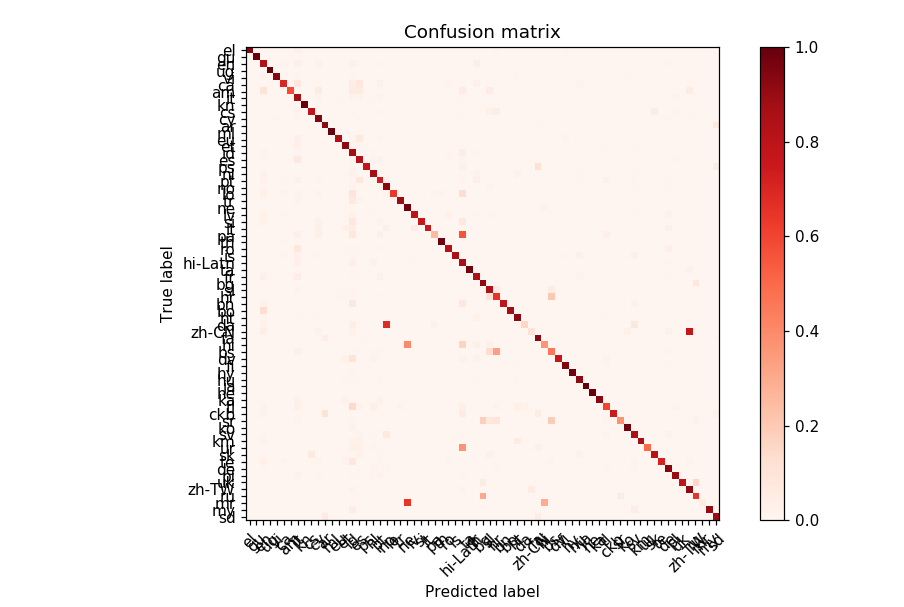

Normalized confusion matrix
[[ 0.94029851  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          1.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.82828283 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.05882353  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.9         0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.88888889]]


In [15]:
%matplotlib notebook
cm = sklearn.metrics.confusion_matrix(expt.y_dev, expt.dev_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm, [expt.num_to_lang[k] for k in xrange(69)], normalize=True)
plt.show()

In [16]:
diags = cm.diagonal()
thres = 0.10
under_peformed = [expt.num_to_lang[i] for i in np.where(diags < thres)[0]]
print('{} / {} underperformed (below {} accuracy)'.format(len(under_peformed), len(diags), thres))
print under_peformed

1 / 69 underperformed (below 0.1 accuracy)
['mr']
